In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
dataseturl='https://www.kaggle.com/datasets/bharatadhikari/humanface8000/data'

In [ ]:
od.download(dataseturl)

Dataset URL: https://www.kaggle.com/datasets/bharatadhikari/humanface8000


100%|██████████| 475M/475M [00:02<00:00, 219MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
from PIL import Image
import shutil

In [ ]:
os.makedirs('/content/test/landscape Images/color', exist_ok=True)
os.makedirs('/content/test/landscape Images/gray', exist_ok=True)

In [ ]:
cnt=0
for filename in os.listdir('/content/humanface8000/landscape Images/color'):
    cnt=cnt+1
    file_path_color = os.path.join('/content/humanface8000/landscape Images/color', filename)
    file_path_gray = os.path.join('/content/humanface8000/landscape Images/gray', filename)
    if os.path.isfile(file_path_color) and os.path.isfile(file_path_gray) and filename.lower().endswith('.jpg'):
        shutil.move(file_path_color, os.path.join('/content/test/landscape Images/color', filename))
        shutil.move(file_path_gray, os.path.join('/content/test/landscape Images/gray', filename))
    if cnt==256:
      break

In [ ]:
imgz=256
batch_size=8
stats =(0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
def denorm(img_tensors):
  return img_tensors*stats[1][0]+stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig,ax=plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
def show_batch(dl, nmax=64):
  for images,_ in dl:
    show_images(images,nmax)
    break

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)
class DeviceDataLoader():
  def __init__(self,dl,device):
      self.dl=dl
      self.device=device
  def __iter__(self):
      for b in self.dl:
        yield to_device(b,self.device)
  def __len__(self):
      return len(self.dl)

In [ ]:
device = get_default_device()

In [ ]:
class Pix2PixFolderDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform

        self.filenames = sorted(os.listdir(root_A))
        self.filenames = [f for f in self.filenames if f in os.listdir(root_B)]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        input_path = os.path.join(self.root_A, filename)
        target_path = os.path.join(self.root_B, filename)

        input_image = Image.open(input_path).convert("RGB")
        target_image = Image.open(target_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [ ]:
transform = transforms.Compose([
    tf.Resize((256,256)),
    tf.ToTensor(),
    tf.Normalize([0.5], [0.5])
])

In [ ]:
dataset = Pix2PixFolderDataset(root_A="/content/humanface8000/landscape Images/gray", root_B="/content/humanface8000/landscape Images/color", transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=3, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
dataset_test = Pix2PixFolderDataset(root_A="/content/test/landscape Images/gray", root_B="/content/test/landscape Images/color", transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False,num_workers=3, pin_memory=True)

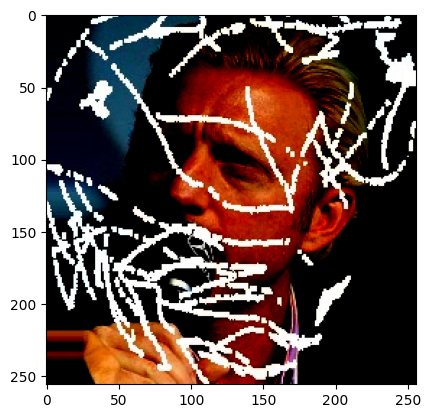

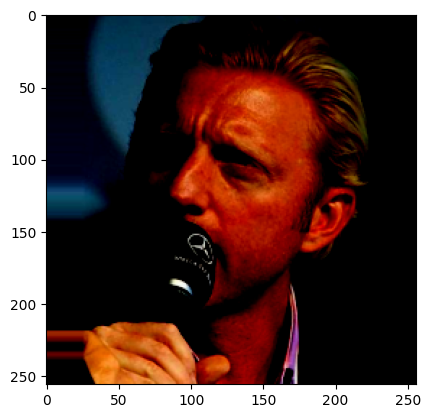

In [ ]:
test_batches = list(test_loader)
#input_img, target_img = next(iter(test_loader))
input_img, target_img =test_batches[1]
plt.imshow(input_img[0].permute(1,2,0))
plt.show()
plt.imshow(target_img[0].permute(1,2,0))
plt.show()

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")  # 4 = kernel_size, 2 = stride, 1 = padding
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)

        return self.dropout(x) if self.use_dropout else x



In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # 128

        self.down1 = Block(features, features*2, down=True, act="leaky", use_dropout=False)         # 64
        self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False)       # 32
        self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False)       # 16
        self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)       # 8
        self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)       # 4
        self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False)       # 2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"), nn.ReLU(),  # 1x1
        )
        self.up1 = Block(features*8, features*8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1))
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))

        return self.final_up(torch.cat([up7, d1], dim=1))

In [ ]:
def train_fn(disc,gen,train_loader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler):
  loop=tqdm(train_loader,leave=True)
  for idx,(x,y) in enumerate(loop):
    x=x.to(device)
    y=y.to(device)
    with torch.cuda.amp.autocast():
      y_fake=gen(x)
      D_real = disc(x, y)
      D_fake = disc(x, y_fake.detach())
      D_real_loss = BCE(D_real, torch.ones_like(D_real))
      D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
      D_loss = (D_real_loss + D_fake_loss) / 2
    disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    with torch.cuda.amp.autocast():
      D_fake = disc(x, y_fake)
      G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
      L1 = L1_LOSS(y_fake, y) * 10
      G_loss = G_fake_loss + L1
    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

  print("Epoch [{}/{}], G_fake_loss: {:.4f} L1: {:.4f},, L1: {:.4f}, G_loss: {:.4f}, D_loss: {:.4f}".format(
        epoch+1, epochs, G_fake_loss,D_real_loss, L1, G_loss, D_loss))

In [ ]:
def train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler, epoch, epochs):
    loop = tqdm(train_loader, leave=True)

    total_G_loss, total_D_loss, total_L1, total_G_fake_loss, total_D_real_loss = 0, 0, 0, 0, 0
    num_batches = len(train_loader)

    for idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)

        #Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            D_real_loss = BCE(D_real, torch.ones_like(D_real))
            D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        #Train Generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
            L1 = L1_LOSS(y_fake, y) * 10
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        total_G_loss += G_loss.item()
        total_D_loss += D_loss.item()
        total_L1 += L1.item()
        total_G_fake_loss += G_fake_loss.item()
        total_D_real_loss += D_real_loss.item()

    avg_G_loss = total_G_loss / num_batches
    avg_D_loss = total_D_loss / num_batches
    avg_L1 = total_L1 / num_batches
    avg_G_fake_loss = total_G_fake_loss / num_batches
    avg_D_real_loss = total_D_real_loss / num_batches

    print(f"Epoch [{epoch+1}/{epochs}] - G_loss: {avg_G_loss:.4f}, D_loss: {avg_D_loss:.4f}, "
          f"L1: {avg_L1:.4f}, G_fake_loss: {avg_G_fake_loss:.4f}, D_real_loss: {avg_D_real_loss:.4f}")


In [ ]:
epochs=50

In [ ]:
def save_examples(generator, val_loader, epoch, folder="saved_images"):
    os.makedirs(folder, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for idx, (input_img, target_img) in enumerate(val_loader):
            input_img, target_img = input_img.to(device), target_img.to(device)
            fake_img = generator(input_img)

            img_grid = torch.cat([input_img, fake_img, target_img], dim=0)

            torchvision.utils.save_image(
                img_grid, f"{folder}/epoch_{epoch}_sample_{idx}.png", normalize=True
            )
            break

    generator.train()

In [ ]:
disc=Discriminator(in_channels=3).to(device)
gen=Generator(in_channels=3).to(device)
opt_disc=optim.Adam(disc.parameters(),lr=2e-4,betas=(0.5,0.999))
opt_gen=optim.Adam(gen.parameters(),lr=2e-4,betas=(0.5,0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


g_scaler= torch.cuda.amp.GradScaler()
d_scaler= torch.cuda.amp.GradScaler()
for epoch in range(epochs):
    train_fn(disc,gen,train_loader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler,epoch,epochs)
    save_examples(gen, test_loader, epoch+1, folder="test_images")


<ipython-input-44-0f0af8f47218>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler= torch.cuda.amp.GradScaler()
<ipython-input-44-0f0af8f47218>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler= torch.cuda.amp.GradScaler()


  0%|          | 0/989 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-43-cfca2831c4bf>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-43-cfca2831c4bf>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/50] - G_loss: 1.6510, D_loss: 0.6866, L1: 0.9209, G_fake_loss: 0.7301, D_real_loss: 0.6866


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [2/50] - G_loss: 1.2707, D_loss: 0.6922, L1: 0.5536, G_fake_loss: 0.7171, D_real_loss: 0.6928


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [3/50] - G_loss: 1.2122, D_loss: 0.6899, L1: 0.4896, G_fake_loss: 0.7226, D_real_loss: 0.6904


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [4/50] - G_loss: 1.2472, D_loss: 0.6775, L1: 0.4720, G_fake_loss: 0.7752, D_real_loss: 0.6795


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [5/50] - G_loss: 1.4281, D_loss: 0.6418, L1: 0.5059, G_fake_loss: 0.9222, D_real_loss: 0.6437


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [6/50] - G_loss: 1.5662, D_loss: 0.6214, L1: 0.5331, G_fake_loss: 1.0332, D_real_loss: 0.6235


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [7/50] - G_loss: 1.7666, D_loss: 0.5795, L1: 0.5588, G_fake_loss: 1.2078, D_real_loss: 0.5809


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [8/50] - G_loss: 1.8839, D_loss: 0.5658, L1: 0.5704, G_fake_loss: 1.3135, D_real_loss: 0.5682


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [9/50] - G_loss: 2.1019, D_loss: 0.5280, L1: 0.5781, G_fake_loss: 1.5238, D_real_loss: 0.5337


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [10/50] - G_loss: 2.6154, D_loss: 0.4456, L1: 0.5934, G_fake_loss: 2.0220, D_real_loss: 0.4521


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [11/50] - G_loss: 3.0164, D_loss: 0.3867, L1: 0.6037, G_fake_loss: 2.4127, D_real_loss: 0.3934


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [12/50] - G_loss: 3.4266, D_loss: 0.3373, L1: 0.6337, G_fake_loss: 2.7929, D_real_loss: 0.3399


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [13/50] - G_loss: 3.9829, D_loss: 0.2494, L1: 0.6541, G_fake_loss: 3.3289, D_real_loss: 0.2511


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [14/50] - G_loss: 4.4450, D_loss: 0.2290, L1: 0.6522, G_fake_loss: 3.7929, D_real_loss: 0.2333


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [15/50] - G_loss: 4.6469, D_loss: 0.1977, L1: 0.7204, G_fake_loss: 3.9265, D_real_loss: 0.2036


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [16/50] - G_loss: 4.8399, D_loss: 0.2091, L1: 0.6439, G_fake_loss: 4.1961, D_real_loss: 0.2187


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [17/50] - G_loss: 5.0608, D_loss: 0.1738, L1: 0.7265, G_fake_loss: 4.3343, D_real_loss: 0.1817


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [18/50] - G_loss: 5.3817, D_loss: 0.1781, L1: 0.8459, G_fake_loss: 4.5358, D_real_loss: 0.1870


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [19/50] - G_loss: 5.7780, D_loss: 0.1253, L1: 0.8499, G_fake_loss: 4.9281, D_real_loss: 0.1250


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [20/50] - G_loss: 6.7802, D_loss: 0.0999, L1: 1.2575, G_fake_loss: 5.5226, D_real_loss: 0.1058


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [21/50] - G_loss: 5.0816, D_loss: 0.1979, L1: 0.5895, G_fake_loss: 4.4921, D_real_loss: 0.2079


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [22/50] - G_loss: 5.6225, D_loss: 0.1570, L1: 0.6073, G_fake_loss: 5.0152, D_real_loss: 0.1602


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [23/50] - G_loss: 6.9106, D_loss: 0.1078, L1: 1.1566, G_fake_loss: 5.7540, D_real_loss: 0.1136


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [24/50] - G_loss: 4.9515, D_loss: 0.1949, L1: 0.5715, G_fake_loss: 4.3800, D_real_loss: 0.1987


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [25/50] - G_loss: 6.0083, D_loss: 0.1209, L1: 0.7555, G_fake_loss: 5.2528, D_real_loss: 0.1213


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [26/50] - G_loss: 5.5850, D_loss: 0.1627, L1: 0.6931, G_fake_loss: 4.8919, D_real_loss: 0.1728


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [27/50] - G_loss: 6.8371, D_loss: 0.0670, L1: 0.9405, G_fake_loss: 5.8966, D_real_loss: 0.0640


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [28/50] - G_loss: 6.2012, D_loss: 0.1428, L1: 0.9607, G_fake_loss: 5.2404, D_real_loss: 0.1446


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [29/50] - G_loss: 6.0179, D_loss: 0.1668, L1: 0.7523, G_fake_loss: 5.2656, D_real_loss: 0.1685


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [30/50] - G_loss: 4.9194, D_loss: 0.2877, L1: 0.5911, G_fake_loss: 4.3283, D_real_loss: 0.2978


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [31/50] - G_loss: 3.8115, D_loss: 0.3366, L1: 0.5951, G_fake_loss: 3.2164, D_real_loss: 0.3387


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [32/50] - G_loss: 6.0766, D_loss: 0.0925, L1: 0.7675, G_fake_loss: 5.3091, D_real_loss: 0.0941


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [33/50] - G_loss: 4.6410, D_loss: 0.3449, L1: 1.0185, G_fake_loss: 3.6225, D_real_loss: 0.3564


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [34/50] - G_loss: 2.5710, D_loss: 0.3989, L1: 0.5237, G_fake_loss: 2.0473, D_real_loss: 0.4052


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [35/50] - G_loss: 3.8532, D_loss: 0.2565, L1: 0.6036, G_fake_loss: 3.2495, D_real_loss: 0.2640


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [36/50] - G_loss: 6.6588, D_loss: 0.1234, L1: 1.3784, G_fake_loss: 5.2804, D_real_loss: 0.1238


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [37/50] - G_loss: 7.4277, D_loss: 0.0382, L1: 1.5935, G_fake_loss: 5.8342, D_real_loss: 0.0379


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [38/50] - G_loss: 8.5648, D_loss: 0.1008, L1: 1.3685, G_fake_loss: 7.1963, D_real_loss: 0.1134


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [39/50] - G_loss: 5.3852, D_loss: 0.2112, L1: 1.3036, G_fake_loss: 4.0816, D_real_loss: 0.2112


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [40/50] - G_loss: 6.6394, D_loss: 0.1129, L1: 0.7024, G_fake_loss: 5.9370, D_real_loss: 0.1154


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [41/50] - G_loss: 6.2623, D_loss: 0.1461, L1: 0.5795, G_fake_loss: 5.6829, D_real_loss: 0.1488


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [42/50] - G_loss: 7.1358, D_loss: 0.1027, L1: 1.3838, G_fake_loss: 5.7520, D_real_loss: 0.1115


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [43/50] - G_loss: 5.1552, D_loss: 0.2338, L1: 0.5968, G_fake_loss: 4.5585, D_real_loss: 0.2428


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [44/50] - G_loss: 7.4129, D_loss: 0.0441, L1: 1.6951, G_fake_loss: 5.7177, D_real_loss: 0.0430


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [45/50] - G_loss: 7.5104, D_loss: 0.1087, L1: 0.9778, G_fake_loss: 6.5326, D_real_loss: 0.1083


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [46/50] - G_loss: 3.6702, D_loss: 0.3297, L1: 0.5349, G_fake_loss: 3.1353, D_real_loss: 0.3440


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [47/50] - G_loss: 5.6544, D_loss: 0.1410, L1: 1.0973, G_fake_loss: 4.5571, D_real_loss: 0.1496


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [48/50] - G_loss: 6.4972, D_loss: 0.0980, L1: 1.2758, G_fake_loss: 5.2214, D_real_loss: 0.0995


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [49/50] - G_loss: 4.8483, D_loss: 0.2639, L1: 0.5947, G_fake_loss: 4.2537, D_real_loss: 0.2771


  0%|          | 0/989 [00:00<?, ?it/s]

Epoch [50/50] - G_loss: 5.1199, D_loss: 0.1684, L1: 0.6156, G_fake_loss: 4.5043, D_real_loss: 0.1723


In [ ]:
torch.save(gen.state_dict(), "generator_weights2.pth")
torch.save(disc.state_dict(), "discriminator_weights2.pth")

In [ ]:
gen = Generator(in_channels=3).to(device)  # Khởi tạo kiến trúc model
gen.load_state_dict(torch.load("generator_weights2.pth"))
gen.eval()  # Chuyển sang chế độ inference

<ipython-input-46-8e8486034e9f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen.load_state_dict(torch.load("generator_weights2.pth"))


Generator(
  (initial_down): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, pa

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
